# Compare power with SCADA

In [1]:
from netCDF4 import Dataset
import numpy as     np
import sys
import os.path
import argparse
import time
import pandas as pd
import utm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import glob

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
def isInsideBox(x,y,box):
    if (box[0][0] <= x) and (x <= box[0][1]) and (box[1][0] <= y) and (y <= box[1][1]):
        return True
    else:
        return False
    
def trimdict(data, fields, trim, timekey='Time'):
    t0 = data[timekey][0]
    timefilter = data[timekey] >= t0+trim
    for v in fields:
        data[v] = data[v][timefilter]
    return
    
def avgcsvs(filelist, fields, trim=0.0):
    avgdict = {}
    for v in fields:
        avgdict[v] = None
    for f in filelist:
        df = pd.read_csv(f)
        for v in fields:
            if avgdict[v] is None:
                N = len(df[v].to_numpy()) - 2
                avgdict[v] = df[v].to_numpy()[:N]
            else:
                N = len(avgdict[v])
                avgdict[v] += df[v].to_numpy()[:N]
    for v in fields:
        avgdict[v] /= float(len(filelist))
    if trim>0.0:
        trimdict(avgdict, fields, trim)
    return avgdict

In [3]:
figdir='images/'

# this is the location of the SCADA data netcdf file
SCADAdir = '/projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase3/Data/'

ncfile = 'KP_SCADA_phase3.nc'
KPcsv  = 'KP_turbine_locations.csv'

In [4]:
dat=Dataset(SCADAdir+ncfile, 'r')
KPdat = pd.read_csv(KPcsv)

In [5]:
frontbox = [[0, 700000], [4.02E6, 4.0265E6]]
backbox = [[0, 700000], [4.03E6, 4.035E6]]       #backbox = [[0, 700000], [4.029E6, 4.035E6]]
backWbox = [[0, 638000], [4.03E6, 4.035E6]]      #637700
backEbox = [[638000, 700000], [4.03E6, 4.035E6]] #637700
midbox = [[632500, 638000], [4.027E6, 4.029E6]]  #midbox = [[632500, 637800], [4.027E6, 4.029E6]]

S_frontturbs = []
S_backturbs = []
S_backEturbs= []
S_backWturbs= []
S_midturbs = []

for r in KPdat.iterrows():
    i = r[0]
    x, y = r[1]['Easting'], r[1]['Northing']
    color='k'
    #if (frontbox[0][0] <= x) and (x <= frontbox[0][1]) and (frontbox[1][0] <= y) and (y <= frontbox[1][1]):
    if isInsideBox(x,y, frontbox):
        S_frontturbs.append(i)
    if isInsideBox(x,y, backbox):
        S_backturbs.append(i)
    if isInsideBox(x,y, backEbox):
        S_backEturbs.append(i)        
        
    if isInsideBox(x,y, backWbox):
        S_backWturbs.append(i)        
        
    if isInsideBox(x,y, midbox):
        S_midturbs.append(i)

In [6]:
# Get SCADA power
tSCADA= dat['time'][:]

# Mask out times between 05:00 and 07:00
tmask = (5<=(tSCADA/60)) & ((tSCADA/60)<=7)

meanP = np.mean(dat['Power'][:,:], axis=1)
meanF=np.mean(dat['Power'][:,S_frontturbs], axis=1)
meanB=np.mean(dat['Power'][:,S_backturbs], axis=1)
meanBE=np.mean(dat['Power'][:,S_backEturbs], axis=1)
meanBW=np.mean(dat['Power'][:,S_backWturbs], axis=1)
meanM=np.mean(dat['Power'][:,S_midturbs], axis=1)

## Get AMR-Wind Power

In [7]:
farmcsvfile = '../input_files//turbines_farmrun.csv'
farmdf = pd.read_csv(farmcsvfile)

<Figure size 900x600 with 0 Axes>

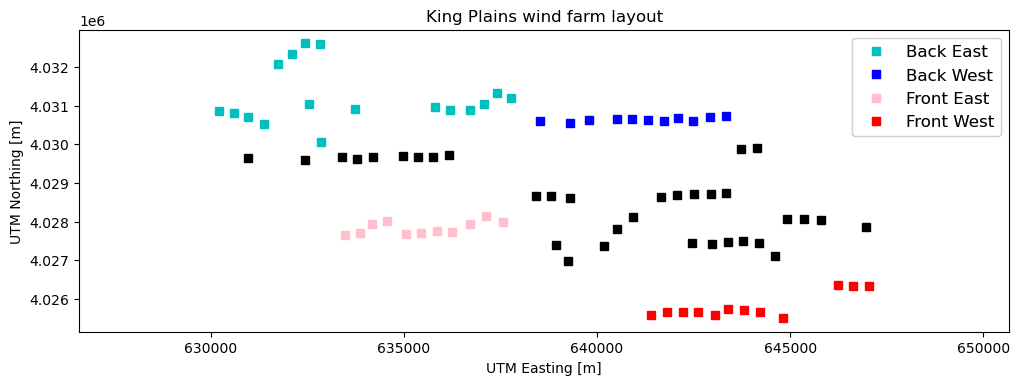

In [8]:
plt.figure(figsize=(6,4), dpi=150)

frontturbs = []
backturbs = []
backEturbs= []
backWturbs= []
midturbs = []

insidebox = [[637500, 800000], [4.0265E6, 4.030E6]]
insideturbs = []

allturbs = []

plt.figure(figsize=(12,4), dpi=100)
for r in farmdf.iterrows():
    name = r[1]['# name']
    allturbs.append(name)
    i = r[0]
    x, y = r[1][' x'], r[1][' y']
    color='k'
    #if (frontbox[0][0] <= x) and (x <= frontbox[0][1]) and (frontbox[1][0] <= y) and (y <= frontbox[1][1]):
    if isInsideBox(x,y, frontbox):
        frontturbs.append(name)
        color='r'
    if isInsideBox(x,y, backbox):
        backturbs.append(name)
    if isInsideBox(x,y, backEbox):
        backEturbs.append(name)        
        color='b'
    if isInsideBox(x,y, backWbox):
        backWturbs.append(name)        
        color='c'        
    if isInsideBox(x,y, midbox):
        midturbs.append(name)
        color='pink'
    if isInsideBox(x,y, insidebox):
        insideturbs.append(name)
        #color='k'

    plt.plot(x,y , 's', color=color)
plt.axis('equal')
plt.ylabel('UTM Northing [m]')
plt.xlabel('UTM Easting [m]')
plt.title('King Plains wind farm layout')

legend1 = plt.legend([Line2D([0],[0], linestyle='None', marker='s', color='c', lw=0.75), 
                      Line2D([0],[0], linestyle='None', marker='s', color='b', lw=0.75), 
                      Line2D([0],[0], linestyle='None', marker='s', color='pink', lw=0.75),
                      Line2D([0],[0], linestyle='None', marker='s', color='r', lw=0.75),
                     ], 
                     ['Back East',
                      'Back West',
                      'Front East',
                      'Front West'], 
                     fontsize=12, frameon=True, loc='upper right')
plt.gca().add_artist(legend1)

plt.savefig(figdir+'/KP_row_categories.png')

In [9]:
rundirA = 'OFRESULTS_RUNA'
rundirA1= 'OFRESULTS_RUNA1'
rundirA2= 'OFRESULTS_RUNA2'
rundirA3= 'OFRESULTS_RUNA3'

fields = ['Time', 'GenPwr', 'NacYaw']

trimtime = 100

all_avgA = avgcsvs([rundirA+'/%s.csv'%iturb for iturb in allturbs], fields, trim=trimtime)
all_avgA1= avgcsvs([rundirA1+'/%s.csv'%iturb for iturb in allturbs], fields, trim=trimtime)
all_avgA2= avgcsvs([rundirA2+'/%s.csv'%iturb for iturb in allturbs], fields, trim=trimtime)
all_avgA3= avgcsvs([rundirA3+'/%s.csv'%iturb for iturb in allturbs], fields, trim=trimtime*0.7)

front_avgA = avgcsvs([rundirA+'/%s.csv'%iturb for iturb in frontturbs], fields, trim=trimtime)
back_avgA  = avgcsvs([rundirA+'/%s.csv'%iturb for iturb in backturbs], fields, trim=trimtime)
backE_avgA = avgcsvs([rundirA+'/%s.csv'%iturb for iturb in backEturbs], fields, trim=trimtime)
backW_avgA = avgcsvs([rundirA+'/%s.csv'%iturb for iturb in backWturbs], fields, trim=trimtime)
mid_avgA   = avgcsvs([rundirA+'/%s.csv'%iturb for iturb in midturbs], fields, trim=trimtime)

front_avgA1 = avgcsvs([rundirA1+'/%s.csv'%iturb for iturb in frontturbs], fields, trim=trimtime)
back_avgA1  = avgcsvs([rundirA1+'/%s.csv'%iturb for iturb in backturbs], fields, trim=trimtime)
backE_avgA1 = avgcsvs([rundirA1+'/%s.csv'%iturb for iturb in backEturbs], fields, trim=trimtime)
backW_avgA1 = avgcsvs([rundirA1+'/%s.csv'%iturb for iturb in backWturbs], fields, trim=trimtime)
mid_avgA1   = avgcsvs([rundirA1+'/%s.csv'%iturb for iturb in midturbs], fields, trim=trimtime)

front_avgA2 = avgcsvs([rundirA2+'/%s.csv'%iturb for iturb in frontturbs], fields, trim=trimtime)
back_avgA2  = avgcsvs([rundirA2+'/%s.csv'%iturb for iturb in backturbs], fields, trim=trimtime)
backE_avgA2 = avgcsvs([rundirA2+'/%s.csv'%iturb for iturb in backEturbs], fields, trim=trimtime)
backW_avgA2 = avgcsvs([rundirA2+'/%s.csv'%iturb for iturb in backWturbs], fields, trim=trimtime)
mid_avgA2   = avgcsvs([rundirA2+'/%s.csv'%iturb for iturb in midturbs], fields, trim=trimtime)

front_avgA3 = avgcsvs([rundirA3+'/%s.csv'%iturb for iturb in frontturbs], fields, trim=trimtime*0.7)
back_avgA3  = avgcsvs([rundirA3+'/%s.csv'%iturb for iturb in backturbs], fields, trim=trimtime*0.7)
backE_avgA3 = avgcsvs([rundirA3+'/%s.csv'%iturb for iturb in backEturbs], fields, trim=trimtime*0.7)
backW_avgA3 = avgcsvs([rundirA3+'/%s.csv'%iturb for iturb in backWturbs], fields, trim=trimtime*0.7)
mid_avgA3   = avgcsvs([rundirA3+'/%s.csv'%iturb for iturb in midturbs], fields, trim=trimtime*0.7)

## Plot comparison

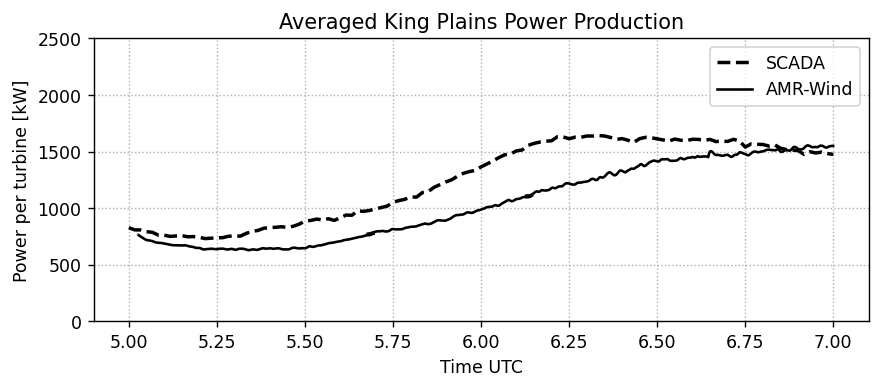

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,3),dpi=125)
plt.plot(tSCADA[tmask]/60.0, meanP[tmask], color='k', lw=2, ls='--', label='SCADA')

plt.plot(all_avgA['Time']/3600+5,  all_avgA['GenPwr'], 'k',  label='AMR-Wind')
dtA1=2340
plt.plot((all_avgA1['Time']+dtA1)/3600+5,  all_avgA1['GenPwr'], 'k', )

dtA2=3960
plt.plot((all_avgA2['Time']+dtA2)/3600+5,  all_avgA2['GenPwr'], 'k', )

dtA3=5850
plt.plot((all_avgA3['Time']+dtA3)/3600+5,  all_avgA3['GenPwr'], 'k', )

plt.ylim([0, 2500])
plt.grid(ls=':')
plt.legend()
plt.xlabel('Time UTC')
plt.ylabel('Power per turbine [kW]')
plt.title('Averaged King Plains Power Production')

plt.savefig(figdir+'/KP_AVG_Power_Comparison.png')

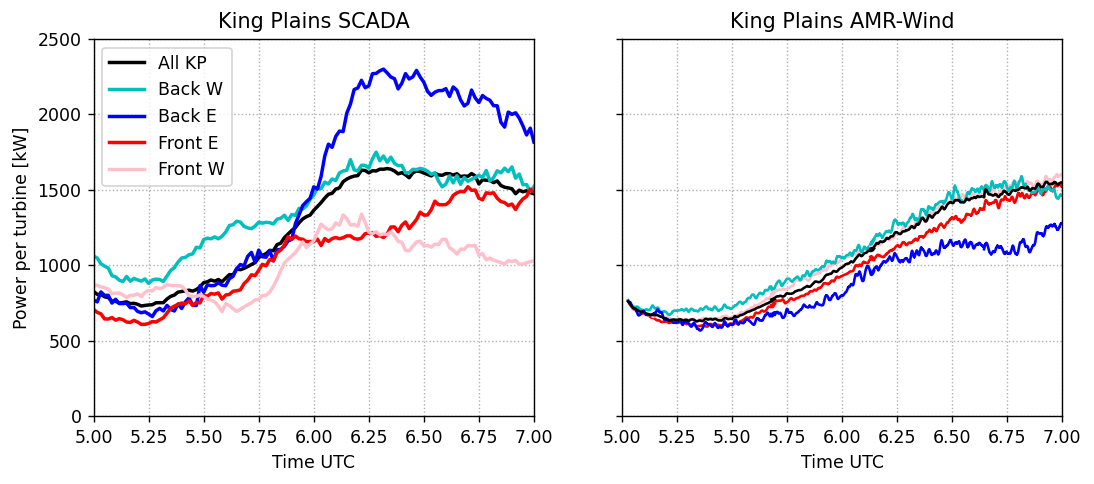

In [11]:
fig, axs = plt.subplots(1,2,figsize=(10,4),dpi=125, sharey=True)

ax=axs[0]
ax.plot(tSCADA[tmask]/60.0, meanP[tmask], color='k', lw=2, label='All KP')
ax.plot(tSCADA[tmask]/60.0, meanBW[tmask], color='c', lw=2, label='Back W')
ax.plot(tSCADA[tmask]/60.0, meanBE[tmask], color='b', lw=2, label='Back E')
ax.plot(tSCADA[tmask]/60.0, meanF[tmask], color='r', lw=2, label='Front E')
ax.plot(tSCADA[tmask]/60.0, meanM[tmask], color='pink', lw=2, label='Front W')

shiftt = lambda t: t/3600+5
dtA1=2340
dtA2=3960
dtA3=5850

ax=axs[1]
ax.plot(shiftt(front_avgA['Time']), front_avgA['GenPwr'], 'r', label='Front E')
ax.plot(shiftt(mid_avgA['Time']), mid_avgA['GenPwr'], 'pink',   label='Front W')
ax.plot(shiftt(backW_avgA['Time']), backW_avgA['GenPwr'], 'c', label='Back W')
ax.plot(shiftt(backE_avgA['Time']), backE_avgA['GenPwr'], 'b', label='Back E')
ax.plot(shiftt(all_avgA['Time']),  all_avgA['GenPwr'], 'k',  label='All KP')

ax.plot(shiftt(front_avgA1['Time']+dtA1), front_avgA1['GenPwr'], 'r', label='Front E')
ax.plot(shiftt(mid_avgA1['Time']+dtA1), mid_avgA1['GenPwr'], 'pink',   label='Front W')
ax.plot(shiftt(backW_avgA1['Time']+dtA1), backW_avgA1['GenPwr'], 'c', label='Back W')
ax.plot(shiftt(backE_avgA1['Time']+dtA1), backE_avgA1['GenPwr'], 'b', label='Back E')
ax.plot(shiftt(all_avgA1['Time']+dtA1),  all_avgA1['GenPwr'], 'k',  label='All KP')

ax.plot(shiftt(front_avgA2['Time']+dtA2), front_avgA2['GenPwr'], 'r', label='Front E')
ax.plot(shiftt(mid_avgA2['Time']+dtA2),   mid_avgA2['GenPwr'], 'pink',   label='Front W')
ax.plot(shiftt(backW_avgA2['Time']+dtA2), backW_avgA2['GenPwr'], 'c', label='Back W')
ax.plot(shiftt(backE_avgA2['Time']+dtA2), backE_avgA2['GenPwr'], 'b', label='Back E')
ax.plot(shiftt(all_avgA2['Time']+dtA2),   all_avgA2['GenPwr'], 'k',  label='All KP')

ax.plot(shiftt(front_avgA3['Time']+dtA3), front_avgA3['GenPwr'], 'r', label='Front E')
ax.plot(shiftt(mid_avgA3['Time']+dtA3),   mid_avgA3['GenPwr'], 'pink',   label='Front W')
ax.plot(shiftt(backW_avgA3['Time']+dtA3), backW_avgA3['GenPwr'], 'c', label='Back W')
ax.plot(shiftt(backE_avgA3['Time']+dtA3), backE_avgA3['GenPwr'], 'b', label='Back E')
ax.plot(shiftt(all_avgA3['Time']+dtA3),   all_avgA3['GenPwr'], 'k',  label='All KP')

for ax in axs:
    ax.set_ylim([0, 2500])
    ax.set_xlim([5,7])
    ax.grid(ls=':')
    ax.set_xlabel('Time UTC')
    
axs[0].set_ylabel('Power per turbine [kW]')
axs[0].legend()
axs[0].set_title('King Plains SCADA')
axs[1].set_title('King Plains AMR-Wind')

plt.savefig(figdir+'/KP_AVG_Power_Row_Comparison.png')

Text(0.5, 1.0, 'King Plains AMR-Wind')

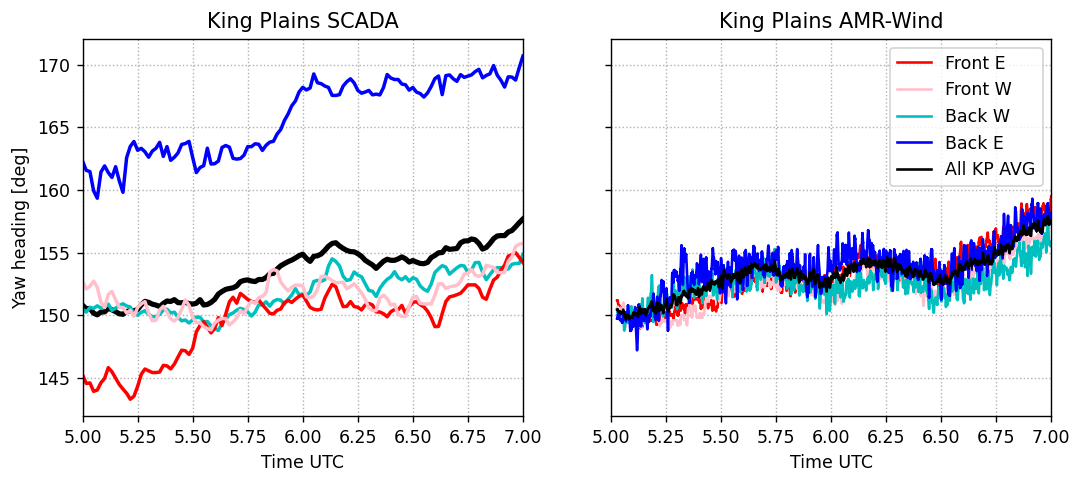

In [12]:
fig, axs = plt.subplots(1,2,figsize=(10,4),dpi=125, sharey=True)

meanYaw = np.mean(dat['Yaw'][:,:], axis=1)
meanYF=np.mean(dat['Yaw'][:,S_frontturbs], axis=1)
meanYB=np.mean(dat['Yaw'][:,S_backturbs], axis=1)
meanYBE=np.mean(dat['Yaw'][:,S_backEturbs], axis=1)
meanYBW=np.mean(dat['Yaw'][:,S_backWturbs], axis=1)
meanYM=np.mean(dat['Yaw'][:,S_midturbs], axis=1)

ax=axs[0]
ax.plot(tSCADA[tmask]/60.0, meanYaw[tmask], color='k', lw=3, label='All KP avg')
ax.plot(tSCADA[tmask]/60.0, meanYBW[tmask], color='c', lw=2, label='Back W avg')
ax.plot(tSCADA[tmask]/60.0, meanYBE[tmask], color='b', lw=2, label='Back E avg')
ax.plot(tSCADA[tmask]/60.0, meanYF[tmask], color='r', lw=2, label='Front E avg')
ax.plot(tSCADA[tmask]/60.0, meanYM[tmask], color='pink', lw=2, label='Front W avg')

shiftt = lambda t: t/3600+5
amrYaw = lambda x: 270-x
dtA1=2340
dtA2=3960
dtA3=5850

ax=axs[1]
ax.plot(shiftt(front_avgA['Time']), amrYaw(front_avgA['NacYaw']), 'r', label='Front E')
ax.plot(shiftt(mid_avgA['Time']), amrYaw(mid_avgA['NacYaw']), 'pink',   label='Front W')
ax.plot(shiftt(backW_avgA['Time']), amrYaw(backW_avgA['NacYaw']), 'c', label='Back W')
ax.plot(shiftt(backE_avgA['Time']), amrYaw(backE_avgA['NacYaw']), 'b', label='Back E')
ax.plot(shiftt(all_avgA['Time']),  amrYaw(all_avgA['NacYaw']), 'k',  label='All KP AVG')

ax.plot(shiftt(front_avgA1['Time']+dtA1), amrYaw(front_avgA1['NacYaw']), 'r', )
ax.plot(shiftt(mid_avgA1['Time']+dtA1),   amrYaw(mid_avgA1['NacYaw']), 'pink',)
ax.plot(shiftt(backW_avgA1['Time']+dtA1), amrYaw(backW_avgA1['NacYaw']), 'c', )
ax.plot(shiftt(backE_avgA1['Time']+dtA1), amrYaw(backE_avgA1['NacYaw']), 'b', )
ax.plot(shiftt(all_avgA1['Time']+dtA1),   amrYaw(all_avgA1['NacYaw']), 'k',   )

ax.plot(shiftt(front_avgA2['Time']+dtA2), amrYaw(front_avgA2['NacYaw']), 'r', )
ax.plot(shiftt(mid_avgA2['Time']+dtA2),   amrYaw(mid_avgA2['NacYaw']), 'pink', )
ax.plot(shiftt(backW_avgA2['Time']+dtA2), amrYaw(backW_avgA2['NacYaw']), 'c', )
ax.plot(shiftt(backE_avgA2['Time']+dtA2), amrYaw(backE_avgA2['NacYaw']), 'b', )
ax.plot(shiftt(all_avgA2['Time']+dtA2),   amrYaw(all_avgA2['NacYaw']), 'k',  )

ax.plot(shiftt(front_avgA3['Time']+dtA3), amrYaw(front_avgA3['NacYaw']), 'r', )
ax.plot(shiftt(mid_avgA3['Time']+dtA3),   amrYaw(mid_avgA3['NacYaw']), 'pink',)
ax.plot(shiftt(backW_avgA3['Time']+dtA3), amrYaw(backW_avgA3['NacYaw']), 'c', )
ax.plot(shiftt(backE_avgA3['Time']+dtA3), amrYaw(backE_avgA3['NacYaw']), 'b', )
ax.plot(shiftt(all_avgA3['Time']+dtA3),   amrYaw(all_avgA3['NacYaw']), 'k',  )

for ax in axs:
    #ax.set_ylim([0, 2500])
    ax.set_xlim([5,7])
    ax.grid(ls=':')
    ax.set_xlabel('Time UTC')
    
axs[0].set_ylabel('Yaw heading [deg]')
axs[1].legend()
axs[0].set_title('King Plains SCADA')
axs[1].set_title('King Plains AMR-Wind')

Text(0.5, 1.0, 'King Plains UTC 5.00 - 6.00 hr UTC')

/projects/netpub/anaconda3/2022.05/lib/python3.9/site-packages/matplotlib/text.py:1419: UserWarning: Warning: converting a masked element to nan.
  x = float(self.convert_xunits(x))
/projects/netpub/anaconda3/2022.05/lib/python3.9/site-packages/matplotlib/text.py:1421: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(y))


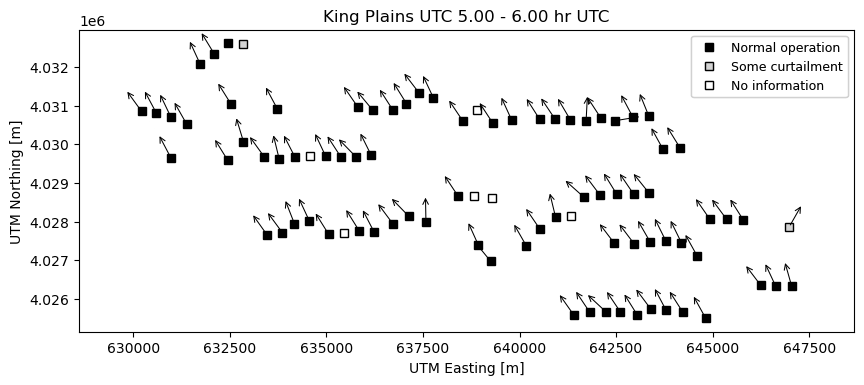

In [13]:
L=700
#t1, t2 = 6.5, 7
#t1, t2 = 5, 5.5
t1, t2 = 5, 6
#t1, t2 = 6, 7
tavg = (t1<=(tSCADA/60)) & ((tSCADA/60)<=t2)

#plt.figure(figsize=(10,4), dpi=100)
fig, ax = plt.subplots(figsize=(10,4), dpi=100)
#for r in farmdf.iterrows():
for i, row in enumerate(KPdat.iterrows()):
    #name = r[1]['# name']
    #i = r[0]
    #x, y = r[1][' x'], r[1][' y']
    #print(row[1])
    x, y = row[1]['Easting'], row[1]['Northing']
       
    turbyaw=dat['Yaw'][:,i]
    avgyaw = np.mean(turbyaw[tavg])
    theta = 270.0 - avgyaw
    #print(name, i, theta, avgyaw)
    u, v = L*np.cos(theta*np.pi/180), L*np.sin(theta*np.pi/180)
    
    curtail = np.mean(dat['Curtailment'][tavg,i])
    if curtail==0.0:
        color='k'
    elif curtail>0.0:
        color='lightgray'
    else:
        color='w'
        
    ax.plot(x,y , 's', color=color, mec='k')
    ax.annotate("", xytext=(x, y), xy=(x+u, y+v),
                arrowprops=dict(arrowstyle="->", lw=0.75))

legend1 = plt.legend([Line2D([0],[0], linestyle='None', marker='s', color='k', lw=0.75), 
                      Line2D([0],[0], linestyle='None',  marker='s', mfc='lightgray', mec='k',lw=0.75), 
                      Line2D([0],[0], linestyle='None',  marker='s', mfc='w', mec='k',lw=0.75), 
                     ], 
                     ['Normal operation','Some curtailment', 'No information' ], 
                     fontsize=9, frameon=True, loc='upper right')

ax.add_artist(legend1)

plt.axis('equal')
plt.ylabel('UTM Northing [m]')
plt.xlabel('UTM Easting [m]')
plt.title('King Plains UTC %.2f - %.2f hr UTC'%(t1,t2))

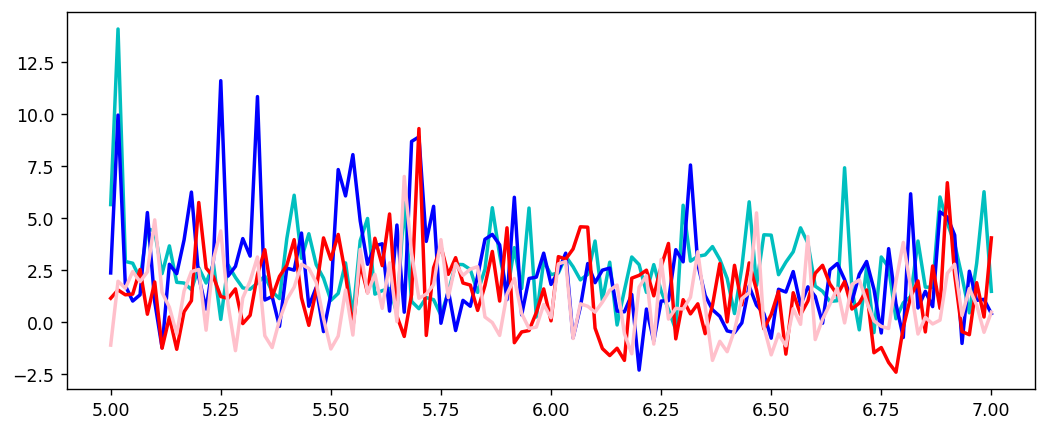

In [14]:
fig, axs = plt.subplots(1,1,figsize=(10,4),dpi=125, sharey=True)

meanYawMA = np.max(dat['Yaw Misalignment'][:,:], axis=1)
meanYMAF=np.max(dat['Yaw Misalignment'][:,S_frontturbs], axis=1)
meanYMAB=np.max(dat['Yaw Misalignment'][:,S_backturbs], axis=1)
meanYMABE=np.max(dat['Yaw Misalignment'][:,S_backEturbs], axis=1)
meanYMABW=np.max(dat['Yaw Misalignment'][:,S_backWturbs], axis=1)
meanYMAM=np.max(dat['Yaw Misalignment'][:,S_midturbs], axis=1)

ax=axs
#ax.plot(tSCADA[tmask]/60.0, meanYawMA[tmask], color='k', lw=3, label='All KP avg')
ax.plot(tSCADA[tmask]/60.0, meanYMABW[tmask], color='c', lw=2, label='Back W avg')
ax.plot(tSCADA[tmask]/60.0, meanYMABE[tmask], color='b', lw=2, label='Back E avg')
ax.plot(tSCADA[tmask]/60.0, meanYMAF[tmask], color='r', lw=2, label='Front E avg')
ax.plot(tSCADA[tmask]/60.0, meanYMAM[tmask], color='pink', lw=2, label='Front W avg')